<a href="https://colab.research.google.com/github/qczhao92/ADAGE-on-L1000/blob/main/ADAGE_Project_Model_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
colab = True
# In case in Colab activate this cell by passing the corect path to the images
if colab==True: 
    from google.colab import drive
    drive.mount('/content/drive')
    work_dir = 'drive/MyDrive/AIforGenomics2021/ADAGE'
else:
    work_dir = ''

Mounted at /content/drive


In [ ]:
import sys, os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# set the path of files
l5data = "/content/drive/MyDrive/AIforGenomics2021/ADAGE/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx"
gene_info_txt = "/content/drive/MyDrive/AIforGenomics2021/ADAGE/GSE70138_Broad_LINCS_gene_info_2017-03-06.txt"
pert_info_txt = "/content/drive/MyDrive/AIforGenomics2021/ADAGE/GSE70138_Broad_LINCS_pert_info.txt"
sig_info_txt = "/content/drive/MyDrive/AIforGenomics2021/ADAGE/GSE70138_Broad_LINCS_sig_info_2017-03-06.txt"
cell_info_txt = "/content/drive/MyDrive/AIforGenomics2021/ADAGE/GSE70138_Broad_LINCS_cell_info_2017-04-28.txt"

# 0. Download L1000 data
download the 2 phase level 5 data to the working directory
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70138

In [ ]:
from tqdm import *
import os

if not os.path.exists(work_dir):
    os.system(f'mkdir -p {work_dir}')

if not os.path.isfile(gene_info_txt):
    gene_info_link ='ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70138/suppl/GSE70138_Broad_LINCS_gene_info_2017-03-06.txt.gz'
    os.system(f'wget -O {gene_info_txt}.gz {gene_info_link}')
    os.system(f'gunzip {gene_info_txt}.gz')

if not os.path.isfile(pert_info_txt):
    pert_info_link ='ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70138/suppl/GSE70138_Broad_LINCS_pert_info.txt.gz'
    os.system(f'wget -O {pert_info_txt}.gz {pert_info_link}')
    os.system(f'gunzip {pert_info_txt}.gz')

if not os.path.isfile(sig_info_txt):
    sig_info_link ='ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70138/suppl/GSE70138_Broad_LINCS_sig_info_2017-03-06.txt.gz'
    os.system(f'wget -O {sig_info_txt}.gz {sig_info_link}')
    os.system(f'gunzip {sig_info_txt}.gz')

if not os.path.isfile(cell_info_txt):
    cell_info_link ='ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70138/suppl/GSE70138_Broad_LINCS_cell_info_2017-04-28.txt.gz'
    os.system(f'wget -O {cell_info_txt}.gz {cell_info_link}')
    os.system(f'gunzip {cell_info_txt}.gz')

if not os.path.isfile(l5data):
    if not os.path.isfile(f'{l5data}.gz'):
        print('downloading L1000 level5 data... could take a while')
        l5data_link ='ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70138/suppl/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx.gz'
        os.system(f'wget -O {l5data} {l5data_link}')
    else:
        print('Zipped L1000 level5 data exits!', f'starting unzip {l5data}.gz')
    os.system(f'gunzip {l5data}.gz')

In [ ]:
!ls /content/drive/MyDrive/AIforGenomics2021/ADAGE -all

total 5999957
-rw------- 1 root root  276119388 Mar 11 22:15  A549_full_gene_expression.csv
-rw------- 1 root root   21735820 Mar  8 19:16  A549_landmark_expression.csv
-rw------- 1 root root      11850 Mar  1 18:07  GSE70138_Broad_LINCS_cell_info_2017-04-28.txt
-rw------- 1 root root     621887 Mar  1 18:07  GSE70138_Broad_LINCS_gene_info_2017-03-06.txt
-rw------- 1 root root 5824120558 Mar  1 18:07  GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx
-rw------- 1 root root     219965 Mar  1 18:07  GSE70138_Broad_LINCS_pert_info.txt
-rw------- 1 root root   18260895 Mar  1 18:07  GSE70138_Broad_LINCS_sig_info_2017-03-06.txt
-rw------- 1 root root     392615 Mar 11 19:04  string_normal_image.png
drwx------ 2 root root       4096 Mar  6 21:02  trained_model
-rw------- 1 root root    2466424 Mar 11 22:21 'weight matrices after training'


## take a look of the information files

In [ ]:
import pandas as pd

gene_info = pd.read_csv(gene_info_txt, sep = '\t')
print(gene_info.shape)
gene_info.head()


(12328, 5)


,pr_gene_id,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing
0,780,DDR1,discoidin domain receptor tyrosine kinase 1,1,1
1,7849,PAX8,paired box 8,1,1
2,2978,GUCA1A,guanylate cyclase activator 1A,0,0
3,2049,EPHB3,EPH receptor B3,0,1
4,2101,ESRRA,estrogen related receptor alpha,0,1


In [ ]:
pert_info = pd.read_csv(pert_info_txt, sep = '\t')
print(pert_info.shape)
pert_info.head()

(2170, 5)


,pert_id,canonical_smiles,inchi_key,pert_iname,pert_type
0,BRD-K70792160,CCN(CC)CCCCN1c2ccccc2Oc2ccc(Cl)cc12,GYBXAGDWMCJZJK-UHFFFAOYSA-N,10-DEBC,trt_cp
1,BRD-K68552125,CCCCCCCCCCCCCC(=O)O[C@@H]1[C@@H](C)[C@]2(O)[C@...,PHEDXBVPIONUQT-RGYGYFBISA-N,phorbol-myristate-acetate,trt_cp
2,BRD-K92301463,CCCCC(C)(C)[C@H](O)\C=C\[C@H]1[C@H](O)CC(=O)[C...,QAOBBBBDJSWHMU-WMBBNPMCSA-N,"16,16-dimethylprostaglandin-e2",trt_cp
3,BRD-A29731977,CCCCCC(=O)O[C@@]1(CCC2C3CCC4=CC(=O)CC[C@]4(C)C...,DOMWKUIIPQCAJU-JKPPDDDBSA-N,17-hydroxyprogesterone-caproate,trt_cp
4,BRD-K07954936,OC(=O)CCCC[C@@H]1SC[C@@H]2NC(=N)N[C@H]12,WWVANQJRLPIHNS-ZKWXMUAHSA-N,2-iminobiotin,trt_cp


In [ ]:
sig_info = pd.read_csv(sig_info_txt, sep = '\t')
print(sig_info.shape)
sig_info.head()

(118050, 8)


,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_idose,pert_itime,distil_id
0,LJP005_A375_24H:A03,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A03|LJP005_A375_24H_X2_...
1,LJP005_A375_24H:A04,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A04|LJP005_A375_24H_X2_...
2,LJP005_A375_24H:A05,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A05|LJP005_A375_24H_X2_...
3,LJP005_A375_24H:A06,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A06|LJP005_A375_24H_X2_...
4,LJP005_A375_24H:A07,BRD-K76908866,CP-724714,trt_cp,A375,10.0 um,24 h,LJP005_A375_24H_X1_B19:A07|LJP005_A375_24H_X2_...


## load L1000 level 5 data (gctx)


In [ ]:
landmark_gene_list = gene_info[gene_info['pr_is_lm'] == 1].astype(str)
print(landmark_gene_list.shape)
landmark_gene_list.head()

(978, 5)


,pr_gene_id,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing
0,780,DDR1,discoidin domain receptor tyrosine kinase 1,1,1
1,7849,PAX8,paired box 8,1,1
25,6193,RPS5,ribosomal protein S5,1,1
43,23,ABCF1,ATP binding cassette subfamily F member 1,1,1
49,9552,SPAG7,sperm associated antigen 7,1,1


In [ ]:
!pip install cmapPy

     |████████████████████████████████| 153kB 5.9MB/s 


In [ ]:
## load the full gene expression data
#from cmapPy.pandasGEXpress.parse import parse
#gene_expr_matrix_full = parse(l5data).data_df.T

## extract full gene data of A549:
#A549_gene_expr = gene_expr_matrix_full.loc[["_A549_" in row_name for row_name in gene_expr_matrix_full.index]]
#print(A549_gene_expr.shape)
## save the A549 data for future use
#A549_gene_expr.to_csv(f"{work_dir}/A549_full_gene_expression.csv")

#A549_gene_expr.head()

# del gene_expr_matrix_full  ## release RAM

In [ ]:
## only load landmark genes
from cmapPy.pandasGEXpress.parse import parse

## Load the matrix of differential gene expressions as a pandas dataframe
gene_expr_matrix = parse(l5data, rid=landmark_gene_list["pr_gene_id"]).data_df.T


In [ ]:
## choose a cell line to start with
# see what cell lines are available
print("number of cell lines:", len(sig_info.cell_id.unique()))
sig_info.cell_id.value_counts()

number of cell lines: 41


MCF7        13476
A375        12740
PC3         12719
HT29        12529
HA1E        12481
YAPC        10621
HELA        10617
A549         2082
HCC515       1900
HEPG2        1899
HME1         1895
BT20         1520
HS578T       1516
MDAMB231     1515
MCF10A       1514
SKBR3        1514
NPC.TAK      1283
NPC          1198
ASC          1136
ASC.C        1135
SKL.C        1132
HUVEC        1129
SKL          1128
CD34         1121
NEU          1113
NPC.CAS9     1104
LNCAP         759
PC3.101       380
PC3.311       380
A375.311      380
HELA.311      380
MCF7.101      380
HT29.311      380
HA1E.311      380
YAPC.311      380
A549.311      380
HA1E.101      380
MCF7.311      379
MNEU.E        377
JURKAT        366
HUES3         352
Name: cell_id, dtype: int64

In [ ]:
# extract data of A549:
#A549_gene_expr = gene_expr_matrix.loc[["_A549_" in row_name for row_name in gene_expr_matrix.index]]
#print(A549_gene_expr.shape)
# save the A549 data for future use
#A549_gene_expr.to_csv(f"{work_dir}/A549_landmark_expression.csv")

#A549_gene_expr.head()

# 1. ADAGE model









construct an ADAGE-based model:
1. adding random noise to the input data
2. training a neural network with hidden nodes that were able to remove added noise to reconstruct the initial data

### 1.1 define the model

for each sample $x$:
- add random noise to a percentage of the genes 
- use noise-added sample $x'$ as input of denoising autoencoder

Process input $x'$ with single-layer linear encoder:
> $y = s(Wx'+b)$

then reconstruct gene expression by one-layer or multi-layer decoder:
> $z =  s(W'y + b') $

> keep the last layer of decoder without activation function 

use Mean Squared Error as loss function
> $L(x,z) = \frac{1}{n}\sum_{k=1}^n (x_k  -z_k)^2$


After training, use the weight of encoder $W$ as gene weights.



In [ ]:
class Adage_linear(nn.Module):
    """Denoising Auto-Encoder: to reconstruct the input from a corrupted gene expression"""
    
    def __init__(self, gene_number, node_number = 50, decoder_layers = 1):
        super(Adage_linear, self).__init__()

        hidden_layers = []
        current_node = node_number
        if decoder_layers > 1:
            delta = (gene_number - node_number) / decoder_layers
            for i in range(decoder_layers-1):
                n = int(current_node + delta)
                hidden_layers.append(nn.Linear(current_node, n))
                hidden_layers.append(nn.ReLU(inplace=True))
                current_node = n


        self.encoder = nn.Sequential(
            nn.Linear(gene_number, node_number),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            *hidden_layers,
            nn.Linear(current_node, gene_number)
        )    
      
    def forward(self,x):
        y = self.encoder(x)
        y = self.decoder(y)
        return y


Some functions for training:

In [ ]:
## function to split the training and validation data
def train_valid_split(dataframe, train_portion = 0.7):
    """take a pandas dataframe as input, output two numpy arrays according to train_portion"""
    data = dataframe.to_numpy()
    np.random.shuffle(data)
    train_data, valid_data = data[:int(data.shape[0]*train_portion),:], data[int(data.shape[0]*train_portion):,:]

    print('samples in training data:',train_data.shape[0],'\nsamples in validation data:',valid_data.shape[0])
    return train_data, valid_data

## function to prepare input data
def dataloader(data, batch_size, reuse = True):
    """ prepare a batch of datasets for ADAGE model input """
    np.random.shuffle(data)
    num_batches = len(data) // batch_size
    while True:
        for i in range(num_batches):
            yield data[i * batch_size : (i + 1) * batch_size]
        if not reuse and i == num_batches - 1:
            yield None

## function to save model
def save_models(work_dir, model, epoch_number,model_name):
    """Function to save trained model"""
    save_dir = os.path.join(work_dir, "trained_model",model_name)
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model.state_dict(), '{}/epoch{}'.format(save_dir, epoch_number))


functions for adding noise

In [ ]:
# define an random noise introducer function
def random_noise(train_batch, random_rate = 0.05, std=0.1):
    noise=np.random.normal(0,std,train_batch.shape)
    rate=np.random.choice([0, 1], size=train_batch.shape, p=[1-random_rate, random_rate])
    new_signal=train_batch+noise*rate
    return new_signal


### 1.2 train the model

#### Define the training function

In [ ]:
## training function
def train_model(model, model_name , noise = False, valid_point_epoch = 30 , model_save_epoch = 200 , iteration_n = 15000, print_train = True):
    
    criterion = nn.MSELoss()
    optimizer=optim.Adam(list(model.parameters()), lr=learning_rate)

    start_time = time.time()
    print('training start at %s '%(time.ctime(start_time)),'_'*50)
    train_loss_record = []
    valid_loss_record = []

    for epoch in range(iteration_n): 
        inputs = next(train_loader)
        if noise:
            inputs_n = random_noise(inputs)
        else:
            inputs_n = inputs

        inputs = torch.tensor(inputs).float()
        inputs_n = torch.tensor(inputs_n).float()

        # zero the parameter gradients
        optimizer.zero_grad()
        loss = criterion(model(inputs_n), inputs)
        loss.backward()
        optimizer.step()  # Update the parameters of the model

        # print statistics
        batch_loss = np.mean(loss.item())
        #epochs.append(epoch+1)
        #train_loss.append(batch_loss) 
        train_loss_record.append((epoch+1, batch_loss))

        if print_train and epoch % 50 == 49:    # print every 50 epochs
            print('epoch %d loss: %.3f' %
                  (epoch + 1, np.mean(loss.item())))
        if epoch % valid_point_epoch == valid_point_epoch-1:
            valid_inputs = next(valid_loader)
            valid_inputs = torch.tensor(valid_inputs).float()
            valid_loss = criterion(model(valid_inputs), valid_inputs)
            valid_loss_record.append((epoch+1, np.mean(valid_loss.item())))

        # save check point models
        if epoch % model_save_epoch == model_save_epoch-1:
            save_models(work_dir,model,train_loss_record[-1][0],model_name)
    print('_'*50,'\nFinished Training at', time.ctime(time.time()), '\ntotal training time: %.2f s' %(time.time()-start_time))

    with open(f'{work_dir}/trained_model/{model_name}_train_loss_record.txt','w+') as ft:
        ft.write('\n'.join('%s\t%s' % x for x in train_loss_record))
    with open(f'{work_dir}/trained_model/{model_name}_valid_loss_record.txt','w+') as fv:
        fv.write('\n'.join('%s\t%s' % x for x in valid_loss_record))
    
    %matplotlib inline
    ## plot the training and validation curve
    plt.close()
    plt.plot(*zip(*train_loss_record),color='orange')
    plt.plot(*zip(*valid_loss_record),color='green')
    plt.xlabel("epoch")
    plt.ylabel("MSE")
    plt.savefig(f'{work_dir}/trained_model/{model_name}.pdf')
    
    return model

#### load the data for training and validation

In [ ]:
!pip install cmapPy
## only load landmark genes
from cmapPy.pandasGEXpress.parse import parse
import pandas as pd

gene_info = pd.read_csv(gene_info_txt, sep = '\t')

landmark_gene_list = gene_info[gene_info['pr_is_lm'] == 1].astype(str)
print(landmark_gene_list.shape)
## Load the matrix of differential gene expressions as a pandas dataframe
gene_expr_matrix = parse(l5data, rid=landmark_gene_list["pr_gene_id"]).data_df.T


     |████████████████████████████████| 153kB 7.7MB/s 
(978, 5)


In [ ]:
# define the dataframe to be used
dataf = gene_expr_matrix
# split datasets
train_data, valid_data = train_valid_split(dataf)
# initiate dataloader
train_loader = dataloader(train_data, 80)
valid_loader = dataloader(valid_data,80)

#### Set parameters and launch training

ADAGE Network Architecture:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Adage_linear(
  (encoder): Sequential(
    (0): Linear(in_features=978, out_features=50, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=235, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=235, out_features=420, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=420, out_features=605, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=605, out_features=790, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=790, out_features=978, bias=True)
  )
)

training start at Fri Mar 26 20:30:50 2021  __________________________________________________
__________________________________________________ 
Finished Training at Fri Mar 26 20:40:58 2021 
total training time: 608.36 s


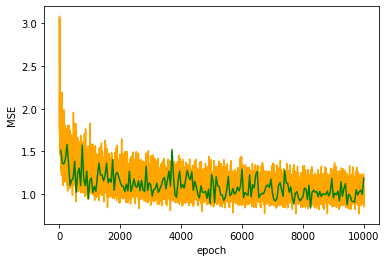

In [ ]:
## set hyper-parameters
node_n=50
layers = 5

learning_rate = 0.002
iteration_n = 10000

model_name=f"{layers}layer_{node_n}nodes_lr{learning_rate}_allsample_landmark_gene"
valid_point_epoch = 50
model_save_epoch = 500

## instantiate the model
DA = Adage_linear(train_data.shape[1], node_number=node_n, decoder_layers = layers)
print("{}\nADAGE Network Architecture:\n{}\n{}\n".format("="*31, "~"*31, DA))

## train the model
DA = train_model(DA, model_name, valid_point_epoch = valid_point_epoch, model_save_epoch = model_save_epoch, iteration_n = iteration_n, print_train = False)

# 2. extracting high-weight genes

from the learned weights of each node, we extract genes corresponding to high weights, aka 2 or more stdev away from mean.

$w_{gene} \geq \bar{w} \pm 2 \sigma $


In [ ]:
# load the trained model
node_n=50
layers = 5

learning_rate = 0.002
epoch_n = 10000

model_name_epoch=f"trial1/{layers}layers_{node_n}nodes_allsample_landmark_gene/epoch{epoch_n}"
DA = Adage_linear(train_data.shape[1], node_number=node_n, decoder_layers = layers)
DA.load_state_dict(torch.load(f'{work_dir}/trained_model/{model_name_epoch}'))
DA.eval()

Adage_linear(
  (encoder): Sequential(
    (0): Linear(in_features=978, out_features=50, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=235, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=235, out_features=420, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=420, out_features=605, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=605, out_features=790, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=790, out_features=978, bias=True)
  )
)

In [ ]:
gene_info = pd.read_csv(gene_info_txt, sep = '\t')
print(gene_info.shape)
#gene_info.head()
landmark_gene = gene_info[gene_info['pr_is_lm'] == 1].astype(str)
print(landmark_gene.shape)
landmark_gene.head()

(12328, 5)
(978, 5)


,pr_gene_id,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing
0,780,DDR1,discoidin domain receptor tyrosine kinase 1,1,1
1,7849,PAX8,paired box 8,1,1
25,6193,RPS5,ribosomal protein S5,1,1
43,23,ABCF1,ATP binding cassette subfamily F member 1,1,1
49,9552,SPAG7,sperm associated antigen 7,1,1


In [ ]:
def extract_high_weight_gene(DAmodel, dataframe = dataf, gene_info_file = gene_info_txt, stdev_cutoff = 2, save = True, 
                             savepath = f'{work_dir}/trained_model/{model_name_epoch}_high_weight_genes.txt'):
    '''
    This function read weight matrix, extract the corresponding gene id from input, and out put a summary dataframe
    '''
    ## load gene info
    gene_info = pd.read_csv(gene_info_file, sep = '\t')
    gene_info['pr_gene_id'] = gene_info['pr_gene_id'].astype(str)

    # get the gene id in the order of training data
    gene_id = dataframe.columns.to_list()
    # subset gene info and organize in the order of gene_id
    gene_df = gene_info.set_index('pr_gene_id').loc[gene_id].reset_index()

    #get the weitht matrix between genes and nodes
    t_weight = DAmodel.encoder[0].weight

    #calculate mean and std at each node of matrix
    w_mean = t_weight.mean(dim=1).reshape(t_weight.shape[0],1)
    w_std = t_weight.std(dim=1).reshape(t_weight.shape[0],1)

    #check for the weights which is more than two std from the mean of each nodes
    t_torf_HW=abs(t_weight-w_mean)- stdev_cutoff*w_std >= 0
   
    #extract and save the genes
    dfs = []
    for i in range(t_torf_HW.shape[0]):
        node_hw = t_torf_HW[i].tolist()
        node_HWgene = gene_df[node_hw]
        node_HWgene.loc[:,'gene_weight'] = t_weight[i][node_hw].tolist()
        node_HWgene.loc[:,'node_id'] = i
        dfs.append(node_HWgene)

    HWgene = pd.concat(dfs)

    if save:
        HWgene.to_csv(savepath, sep='\t',index=False)

    return HWgene

In [ ]:
HWgene = extract_high_weight_gene(DA)
print(HWgene.shape)

HWgene.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

(2226, 7)


,pr_gene_id,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing,gene_weight,node_id
8,533,ATP6V0B,"ATPase, H+ transporting, lysosomal 21kDa, V0 s...",1,1,-0.253299,0
23,823,CAPN1,calpain 1,1,1,-0.193122,0
151,949,SCARB1,scavenger receptor class B member 1,1,1,-0.297632,0
153,6603,SMARCD2,"SWI/SNF related, matrix associated, actin depe...",1,1,-0.226271,0
194,5831,PYCR1,pyrroline-5-carboxylate reductase 1,1,1,-0.230741,0


# 3. Evaluate the learning results


### 3.1 Compare gene sets with protein interaction database (STRING database) 

download and prepare the interaction database 

In [ ]:
# download STRING database for human
#stringdb_path = f'{work_dir}/9606.protein.links.full.v11.0.txt'
stringdb_path = f'{work_dir}/9606.protein.links.v11.0.txt'
if not os.path.isfile(stringdb_path):
    #os.system(f'wget -O {stringdb_path}.gz https://stringdb-static.org/download/protein.links.full.v11.0/9606.protein.links.full.v11.0.txt.gz')
    os.system(f'wget -O {stringdb_path}.gz https://stringdb-static.org/download/protein.links.v11.0/9606.protein.links.v11.0.txt.gz')
    os.system(f'gunzip {stringdb_path}.gz')

stringdb = pd.read_csv(stringdb_path, sep=' ') 
stringdb.head()


,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000272298,490
1,9606.ENSP00000000233,9606.ENSP00000253401,198
2,9606.ENSP00000000233,9606.ENSP00000401445,159
3,9606.ENSP00000000233,9606.ENSP00000418915,606
4,9606.ENSP00000000233,9606.ENSP00000327801,167


useful funtions

In [ ]:
import requests 

def symbol_to_ID(list_of_HUGO_symbol, string_api_url = "https://string-db.org/api", output_format = "tsv-no-header", method = "get_string_ids", species = 9606):  
    '''A function to match HUGO gene symbol (used in L1000) to protein ID (used in STRING)
    return a list of tuples (symbol, STRING_ID)
    (script adapted and modified from STRING API page: https://string-db.org/help/api/)
    '''
    
    params = {
        "identifiers" : "\r".join(list_of_HUGO_symbol), # your protein list
        "species" : species, # species NCBI identifier 
        "limit" : 1, # only one (best) identifier per input protein
        "echo_query" : 1, # see your input identifiers in the output
        "caller_identity" : "ADAGE_project" # your app name
    }

    ## Construct URL
    request_url = "/".join([string_api_url, output_format, method])

    ## Call STRING
    results = requests.post(request_url, data=params)

    ## Read and parse the results
    IDmatch = []
    for line in results.text.strip().split("\n"):
        l = line.split("\t")
        IDmatch.append((l[0], l[2]))
        #input_identifier, string_identifier = l[0], l[2]
        #print("Input:", input_identifier, "STRING:", string_identifier, sep="\t")

    return IDmatch

def extract_STRINGinteractions(gene_df, save = False, save_path = f'{work_dir}/trained_model/stringdb_record.txt'):
    '''the gene_df dataframe must have column "node_id" and "STRING_ID"'''
    links = []
    for i in gene_df['node_id'].unique():
        s_ids = gene_df.loc[gene_df['node_id']==i]['STRING_ID'].tolist()

        g_links = stringdb[stringdb['protein1'].isin(s_ids) & stringdb['protein2'].isin(s_ids)].copy()
        #print(f'=== gene set #{i} ===\n  {len(s_ids)} genes contain {len(g_links.index)} links')
        
        g_links.loc[:,'node_id'] = i
        links.append(g_links)

    total_interactions = pd.concat(links)
    if save:
        total_interactions.to_csv(save_path,sep='\t',index=False)

    return total_interactions

In [ ]:
# build a dictionary of gene symbol to StringID
if os.path.isfile(f'{work_dir}/landmark_gene_STRING_ID.txt'):
    STRINGID_dict = {}
    with open(f'{work_dir}/landmark_gene_STRING_ID.txt') as f:
        for line in f:
            (key, val) = line[:-1].split('\t')
            STRINGID_dict[key] = val
else:
    landmark_gene_STRINGIDs = symbol_to_ID(landmark_gene_list['pr_gene_symbol'])
    with open(f'{work_dir}/landmark_gene_STRING_ID.txt','w+') as f:
        f.write('\n'.join('%s\t%s' % x for x in landmark_gene_STRINGIDs))
    STRINGID_dict = dict(landmark_gene_STRINGIDs)

Look at how many interactions in each gene set

In [ ]:
# get STRING IDs of the high weight genes 
HWgene['STRING_ID'] = [STRINGID_dict[s] for s in HWgene['pr_gene_symbol'].to_list()]
# interactions in each gene set
total_interactions = extract_STRINGinteractions(HWgene,  save=True, save_path= f'{work_dir}/trained_model/{model_name_epoch}_HWgene_stringdb_records.txt')
print(total_interactions.shape)
total_interactions.head()

(13798, 4)


,protein1,protein2,combined_score,node_id
302177,9606.ENSP00000216554,9606.ENSP00000432083,246,0
302184,9606.ENSP00000216554,9606.ENSP00000421689,176,0
302276,9606.ENSP00000216554,9606.ENSP00000318697,173,0
676318,9606.ENSP00000229314,9606.ENSP00000287878,270,0
676388,9606.ENSP00000229314,9606.ENSP00000349860,287,0


To understand the interaction-pair numbers, we estimate interaction-pair number with random genes in L1000:

we generate same number of genesets with same number of random landmark genes in each set

In [ ]:
import random
L1000gene = landmark_gene['pr_gene_symbol'].to_list()

random_gene_list = []
for i in HWgene['node_id'].unique():
    gene_number = HWgene.node_id.value_counts()[i]
    random_gene = random.sample(L1000gene, gene_number)
    random_gene_stringID = [STRINGID_dict[s] for s in random_gene]
    random_df = pd.DataFrame([(x[0],x[1],i) for x in zip(random_gene,random_gene_stringID)], columns=['pr_gene_symbol','STRING_ID','node_id'])
    random_gene_list.append(random_df)

random_genes = pd.concat(random_gene_list)
random_genes.to_csv(f'{work_dir}/trained_model/{model_name_epoch}_random_landmark_genes.txt',sep='\t',index=False)
random_genes.head()

,pr_gene_symbol,STRING_ID,node_id
0,SCP2,9606.ENSP00000360569,0
1,ADGRG1,9606.ENSP00000455215,0
2,HOXA10,9606.ENSP00000283921,0
3,VAT1,9606.ENSP00000347872,0
4,MIF,9606.ENSP00000215754,0


Compare the interaction numbers between high-weight gene sets and random gene sets

In [ ]:
# calculate interactions
random_gene_interaction = extract_STRINGinteractions(random_genes,save=True,save_path=f'{work_dir}/trained_model/{model_name_epoch}_random_landmark_stringdb_records.txt')
# load interactions 
random_gene_interaction = pd.read_csv(f'{work_dir}/trained_model/{model_name_epoch}_random_landmark_stringdb_records.txt',sep='\t')
total_interactions = pd.read_csv(f'{work_dir}/trained_model/{model_name_epoch}_HWgene_stringdb_records.txt',sep='\t')



t-test p = 0.0008602219652915392


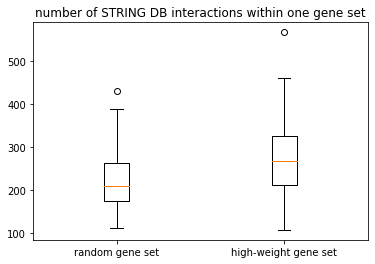

In [ ]:
%matplotlib inline
from scipy import stats

# compare number of interactions
rdata = random_gene_interaction.node_id.value_counts()
hdata = total_interactions.node_id.value_counts()

# perform t-test
t, p = stats.ttest_ind(rdata, hdata)
print('\n\nt-test p =', p)

plt.close()
data = [rdata, hdata]
fig, ax = plt.subplots()
ax.set_title('number of STRING DB interactions within one gene set')
ax.set_xticklabels(['random gene set','high-weight gene set'])
ax.boxplot(data)

plt.show()



t-test p = 0.0025092139788756803


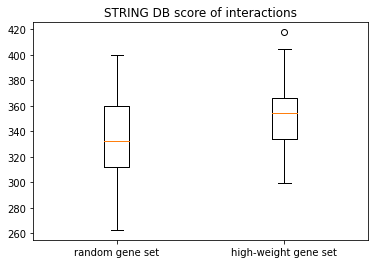

In [ ]:
%matplotlib inline
# compare combined_score of interactions
#rdata = random_gene_interaction.combined_score   # all combined_score
#hdata = total_interactions.combined_score  # all combined_score

rdata = [random_gene_interaction.loc[random_gene_interaction.node_id == i].combined_score.mean() for i in range(50)]   # average combined_score for each node
hdata = [total_interactions.loc[total_interactions.node_id == i].combined_score.mean() for i in range(50)]  # average combined_score for each node

# perform t-test
t, p = stats.ttest_ind(rdata, hdata)
print('\n\nt-test p =', p)

## plot the training and validation curve
plt.close()

data = [rdata, hdata]
fig, ax = plt.subplots()
ax.set_title('STRING DB score of interactions')
ax.set_xticklabels(['random gene set','high-weight gene set'])
ax.boxplot(data)

plt.show()

# Appendix: automatic tools



## trainings with different hyper parameters

samples in training data: 82635 
samples in validation data: 35415
ADAGE Network Architecture:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Adage_linear(
  (encoder): Sequential(
    (0): Linear(in_features=978, out_features=50, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=978, bias=True)
  )
)

training start at Fri Apr 16 03:21:36 2021  __________________________________________________
__________________________________________________ 
Finished Training at Fri Apr 16 03:22:07 2021 
total training time: 31.40 s
ADAGE Network Architecture:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Adage_linear(
  (encoder): Sequential(
    (0): Linear(in_features=978, out_features=50, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=235, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=235, out_features=420, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=4

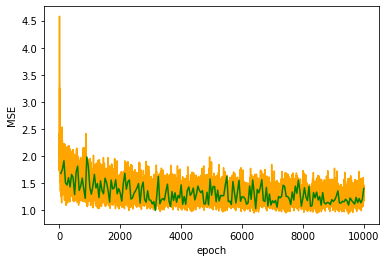

In [ ]:
# define the dataframe to be used
dataf = gene_expr_matrix

noise_add = False
#noise_add = True
iteration_n = 10000

for trial in [1, 2, 3]: # repeat 3 experiments for each model structure
    if noise_add:
        trial_name = f"noise_trial{trial}"
    else:
        trial_name = f"trial{trial}"

    os.makedirs(f"{work_dir}/trained_model/{trial_name}", exist_ok=True)
    # split datasets
    train_data, valid_data = train_valid_split(dataf)
    np.save(f"{work_dir}/trained_model/{trial_name}/train_data_allsample_landmark_gene.npy",train_data)
    np.save(f"{work_dir}/trained_model/{trial_name}/valid_data_allsample_landmark_gene.npy",valid_data)

    # initiate dataloader
    train_loader = dataloader(train_data, 80)
    valid_loader = dataloader(valid_data,80)

    ##### auto train with different hyper-parameters
    iteration_n = 10000

    for node_n in [50, 100]:
        for layers in [1, 5, 10]:

            valid_point_epoch = 50
            model_save_epoch = 500
            learning_rate = 0.002

            ## instantiate the model
            DA = Adage_linear(train_data.shape[1], node_number=node_n, decoder_layers = layers)
            print("{}\nADAGE Network Architecture:\n{}\n{}\n".format("="*31, "~"*31, DA))
            ## train the model
            model_name = f"{trial_name}/{layers}layers_{node_n}nodes_allsample_landmark_gene"
            DA = train_model(DA, model_name,noise=noise_add, valid_point_epoch = valid_point_epoch, model_save_epoch = model_save_epoch, iteration_n = iteration_n, print_train = False)



samples in training data: 82635 
samples in validation data: 35415
ADAGE Network Architecture:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Adage_linear(
  (encoder): Sequential(
    (0): Linear(in_features=978, out_features=50, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=978, bias=True)
  )
)

training start at Fri Apr 16 06:27:20 2021  __________________________________________________
__________________________________________________ 
Finished Training at Fri Apr 16 06:28:54 2021 
total training time: 94.03 s
ADAGE Network Architecture:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Adage_linear(
  (encoder): Sequential(
    (0): Linear(in_features=978, out_features=50, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=235, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=235, out_features=420, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=4

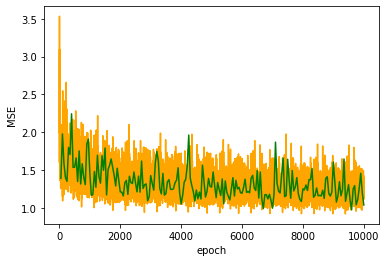

In [ ]:
# define the dataframe to be used
dataf = gene_expr_matrix
noise_add = True
iteration_n = 10000

for trial in [1, 2, 3]: # repeat 3 experiments for each model structure
    if noise_add:
        trial_name = f"noise_trial{trial}"
    else:
        trial_name = f"trial{trial}"

    os.makedirs(f"{work_dir}/trained_model/{trial_name}", exist_ok=True)
    # split datasets
    train_data, valid_data = train_valid_split(dataf)
    np.save(f"{work_dir}/trained_model/{trial_name}/train_data_allsample_landmark_gene.npy",train_data)
    np.save(f"{work_dir}/trained_model/{trial_name}/valid_data_allsample_landmark_gene.npy",valid_data)

    # initiate dataloader
    train_loader = dataloader(train_data, 80)
    valid_loader = dataloader(valid_data,80)

    ##### auto train with different hyper-parameters
    iteration_n = 10000

    for node_n in [50, 100]:
        for layers in [1, 5, 10]:

            valid_point_epoch = 50
            model_save_epoch = 500
            learning_rate = 0.002

            ## instantiate the model
            DA = Adage_linear(train_data.shape[1], node_number=node_n, decoder_layers = layers)
            print("{}\nADAGE Network Architecture:\n{}\n{}\n".format("="*31, "~"*31, DA))
            ## train the model
            model_name = f"{trial_name}/{layers}layers_{node_n}nodes_allsample_landmark_gene"
            DA = train_model(DA, model_name,noise=noise_add, valid_point_epoch = valid_point_epoch, model_save_epoch = model_save_epoch, iteration_n = iteration_n, print_train = False)



## Auto run for evaluating STRING interactions within gene sets:

1. function to compare STRING interactions with random gene interactions

In [ ]:
from scipy import stats
def STRINGdb_compare(HWgene, random_genes, work_dir, model_name_epoch):
    HWgene['STRING_ID'] = [STRINGID_dict[s] for s in HWgene['pr_gene_symbol'].to_list()]
    total_interactions = extract_STRINGinteractions(HWgene,  save=True, save_path= f'{work_dir}/trained_model/{model_name_epoch}_HWgene_stringdb_records.txt')
    random_gene_interaction = extract_STRINGinteractions(random_genes,save=True,save_path=f'{work_dir}/trained_model/{model_name_epoch}_random_landmark_stringdb_records.txt')

    ## plot the number of interactions 
    rdata = random_gene_interaction.node_id.value_counts()
    hdata = total_interactions.node_id.value_counts()
    # perform t-test
    t, p = stats.ttest_ind(rdata, hdata)
    #print('\n\nt-test p =', p)

    plt.close()
    data = [rdata, hdata]
    fig, ax = plt.subplots()
    ax.set_title(f'number of STRING DB interactions within one gene set\nt-test p ={p}')
    ax.set_xticklabels(['random gene set','high-weight gene set'])
    ax.boxplot(data)
    plt.savefig(f'{work_dir}/trained_model/{model_name_epoch}_stringdb_interaction_number.pdf')

    ## plot combined_score of interactions

    rdata2 = [random_gene_interaction.loc[random_gene_interaction.node_id == i].combined_score.mean() for i in range(50)]   # average combined_score for each node
    hdata2 = [total_interactions.loc[total_interactions.node_id == i].combined_score.mean() for i in range(50)]  # average combined_score for each node
    # perform t-test
    t2, p2 = stats.ttest_ind(rdata2, hdata2)
    
    plt.close()
    data2 = [rdata2, hdata2]
    fig, ax = plt.subplots()
    ax.set_title(f'STRING DB score of interactions\nt-test p ={p2}')
    ax.set_xticklabels(['random gene set','high-weight gene set'])
    ax.boxplot(data2)
    plt.savefig(f'{work_dir}/trained_model/{model_name_epoch}_stringdb_interaction_score.pdf')


In [ ]:
## load stringdb ID dictionary
with open(f'{work_dir}/landmark_gene_STRING_ID.txt') as f:
    for line in f:
        (key, val) = line[:-1].split('\t')
        STRINGID_dict[key] = val
## load stringdb interactions
stringdb = pd.read_csv(f'{work_dir}/9606.protein.links.v11.0.txt', sep=' ') 
stringdb.head()

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000272298,490
1,9606.ENSP00000000233,9606.ENSP00000253401,198
2,9606.ENSP00000000233,9606.ENSP00000401445,159
3,9606.ENSP00000000233,9606.ENSP00000418915,606
4,9606.ENSP00000000233,9606.ENSP00000327801,167


2. loop to run different comparisons



In [ ]:
## evaluate interactions in each gene set
# load trained model
epoch_n = 5000

for trial in ['trial1','trial2','trial3','noise_trial1','noise_trial2','noise_trial3']:
    for node_n in [50, 100]:
        for layers in [1, 5, 10]:

            model_name_epoch=f"{trial}/{layers}layers_{node_n}nodes_allsample_landmark_gene/epoch{epoch_n}"
            DA = Adage_linear(train_data.shape[1], node_number=node_n, decoder_layers = layers)
            DA.load_state_dict(torch.load(f'{work_dir}/trained_model/{model_name_epoch}'))

            # extract high weight gene
            HWgene = extract_high_weight_gene(DA)
            HWgene['STRING_ID'] = [STRINGID_dict[s] for s in HWgene['pr_gene_symbol'].to_list()]

            # matplotlib histogram
            t_weight = DA.encoder[0].weight
            node_num = t_weight.shape[0]

            w_mean = t_weight.mean(dim=1).reshape(t_weight.shape[0],1)
            w_std = t_weight.std(dim=1).reshape(t_weight.shape[0],1)

            plt.figure(figsize=(32,node_num))
            for i in range(node_num):
                hwgene_num = len(HWgene.loc[HWgene.node_id == i].index)

                ax = plt.subplot(node_num/5, 5, i + 1)
                ax.hist(t_weight[i].tolist(), color = '#56B4E9', edgecolor = 'white',bins = int(80))
                ax.vlines([(w_mean-2*w_std)[i].item(),(w_mean+2*w_std)[i].item()], ymin=0, ymax=50, colors= 'red')
                ax.vlines(w_mean[i].item(), ymin=0, ymax=50, colors= 'red',linestyles='dashed')
                # Add labels
                ax.set_title(f'weight distribution from node #{i}\n number of high-weight genes: {hwgene_num}')
                ax.set_xlabel('gene weight')
                ax.set_ylabel('genes')

            plt.tight_layout()
            plt.savefig(f"{work_dir}/trained_model/{trial}/{layers}layers_{node_n}nodes_allsample_landmark_gene/epoch{epoch_n}_weight_distribution.pdf")
            plt.close()

            # generate random gene set
            import random
            L1000gene = landmark_gene_list['pr_gene_symbol'].to_list()
            random_gene_list = []
            for i in HWgene['node_id'].unique():
                gene_number = HWgene.node_id.value_counts()[i]
                random_gene = random.sample(L1000gene, gene_number)
                random_gene_stringID = [STRINGID_dict[s] for s in random_gene]
                random_df = pd.DataFrame([(x[0],x[1],i) for x in zip(random_gene,random_gene_stringID)], columns=['pr_gene_symbol','STRING_ID','node_id'])
                random_gene_list.append(random_df)
            random_genes = pd.concat(random_gene_list)
            random_genes.to_csv(f'{work_dir}/trained_model/{model_name_epoch}_random_landmark_genes.txt',sep='\t',index=False)
            random_genes.head()

            # compare the interactions
            STRINGdb_compare(HWgene, random_genes, work_dir, model_name_epoch)
    


## Calculate $r^2$ score

=== trial1/1layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.49272635308330837


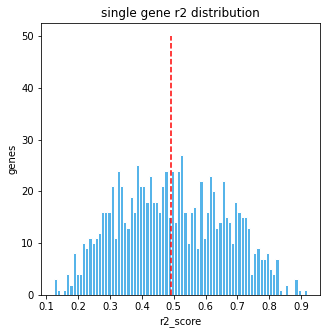

=== trial1/5layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.47049371842292237


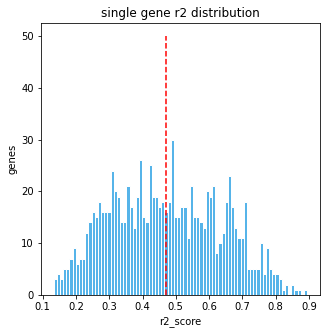

=== trial1/10layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.3681148543049696


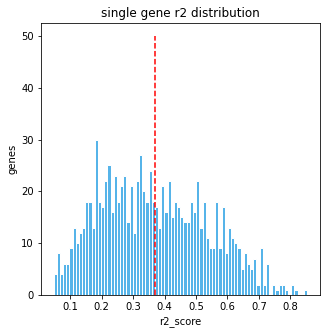

=== trial1/1layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.544227006884306


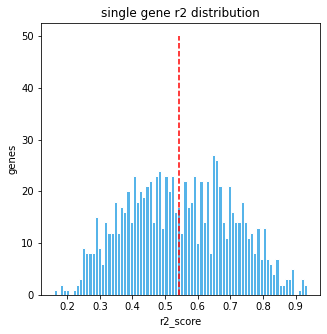

=== trial1/5layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.47322029221943546


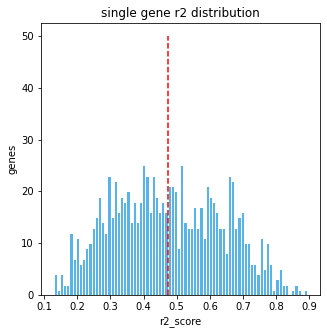

=== trial1/10layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.37896883352773164


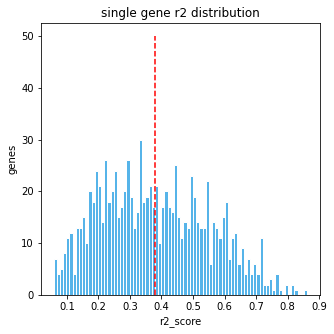

=== trial2/1layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.4816234474319709


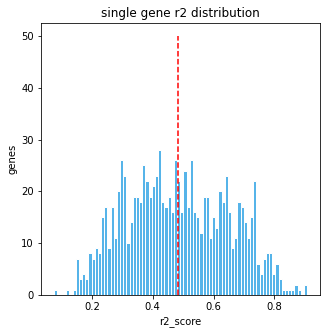

=== trial2/5layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.4652604828859224


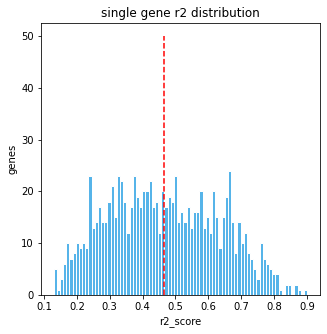

=== trial2/10layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.3330795839557285


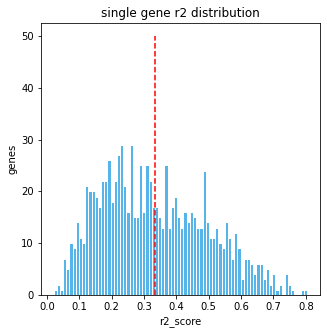

=== trial2/1layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.5388968011509241


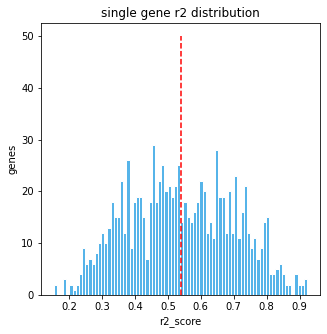

=== trial2/5layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.47707525549874347


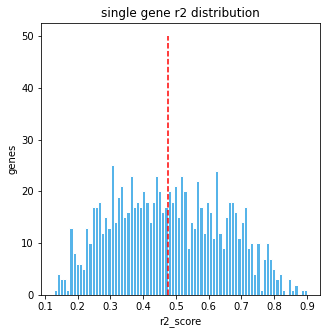

=== trial2/10layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.3755756724533088


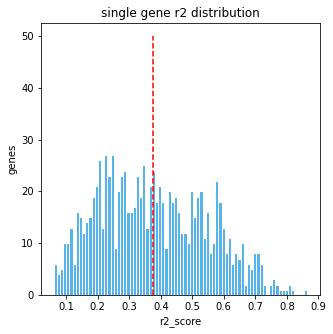

=== trial3/1layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.4887399517295668


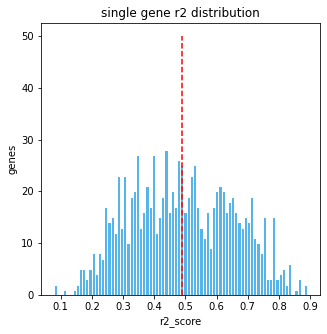

=== trial3/5layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.4786182214289981


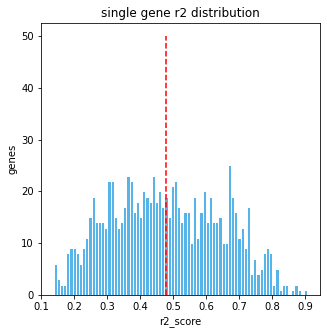

=== trial3/10layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.3701592248622593


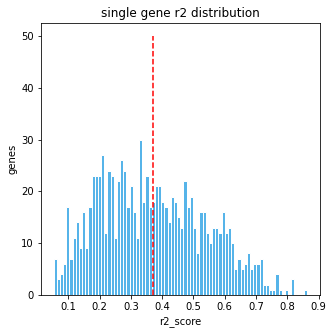

=== trial3/1layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.5514416238570417


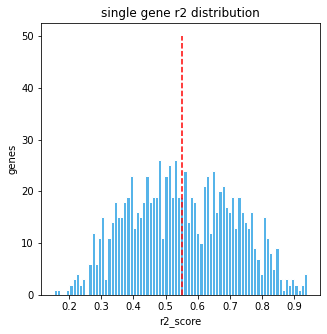

=== trial3/5layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.46940779324714443


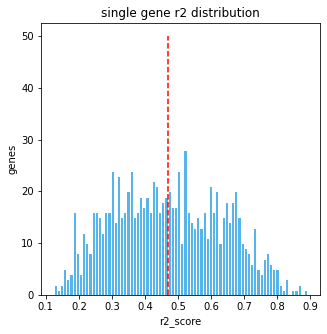

=== trial3/10layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.34156932881356383


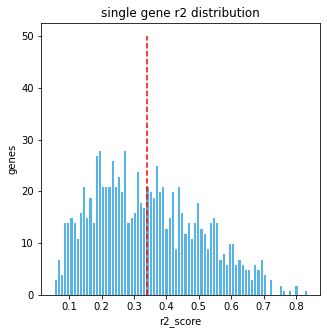

=== noise_trial1/1layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.48743127293801336


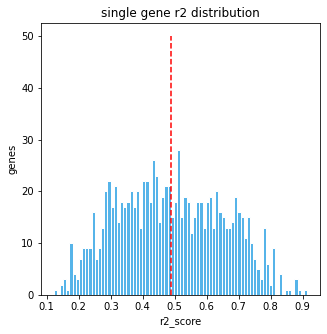

=== noise_trial1/5layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.47053734410631304


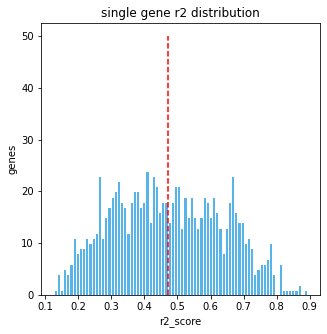

=== noise_trial1/10layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.3749939934566708


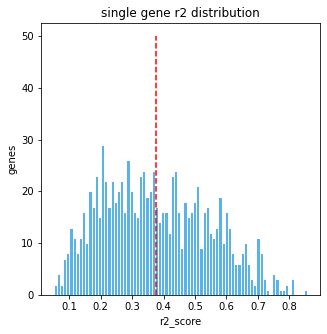

=== noise_trial1/1layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.5395252340472297


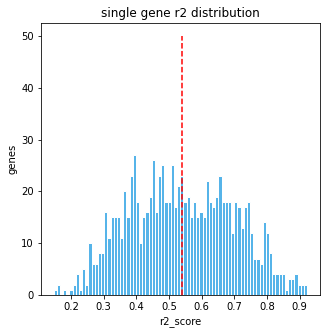

=== noise_trial1/5layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.4713657698389191


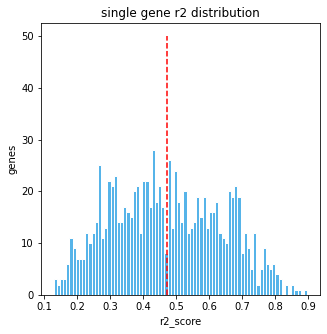

=== noise_trial1/10layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.30603452707684725


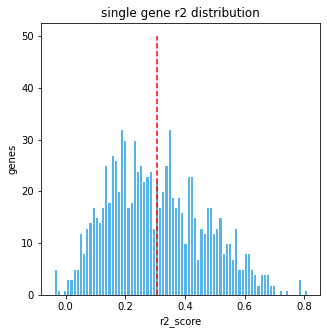

=== noise_trial2/1layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.4852907946932625


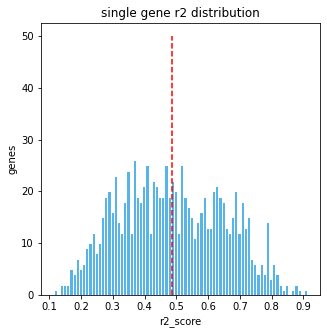

=== noise_trial2/5layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.47528025277399466


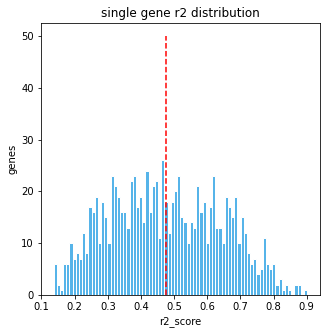

=== noise_trial2/10layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.3573022610494219


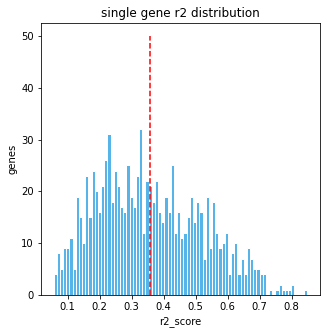

=== noise_trial2/1layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.5378463453326968


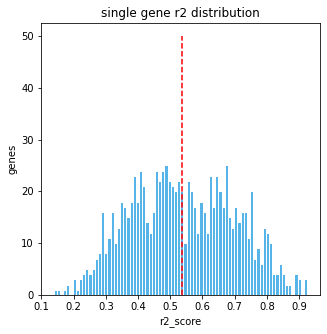

=== noise_trial2/5layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.47458709988960057


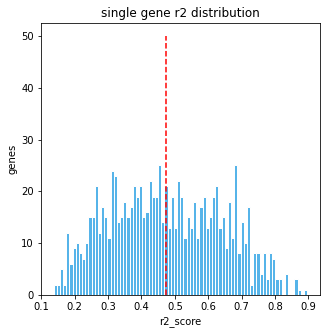

=== noise_trial2/10layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.36130326136206464


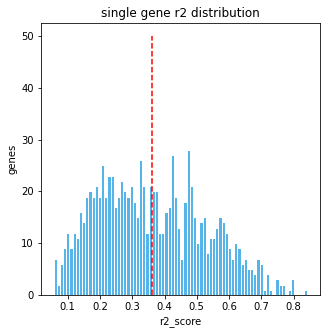

=== noise_trial3/1layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.468424316205941


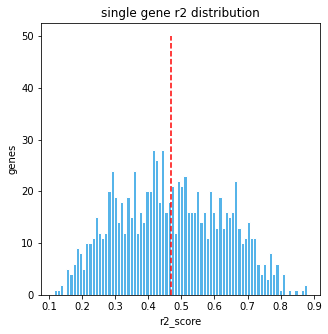

=== noise_trial3/5layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.47399751442903076


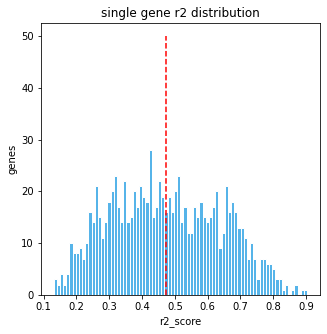

=== noise_trial3/10layers_50nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.38563812450345764


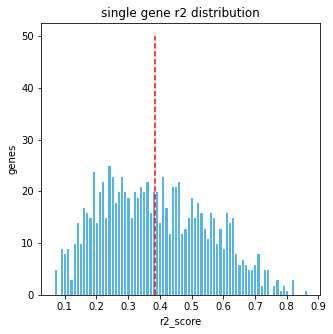

=== noise_trial3/1layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.5381147975703795


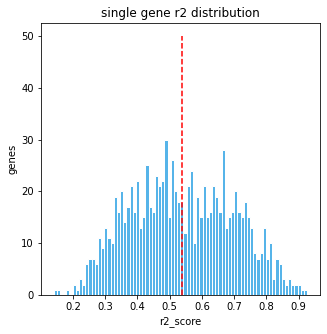

=== noise_trial3/5layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.47964553746536753


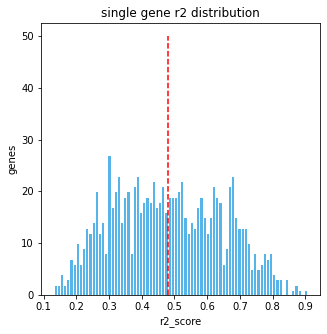

=== noise_trial3/10layers_100nodes_allsample_landmark_gene/epoch5000
average r2 score on valid dataset: 0.3676184187809084


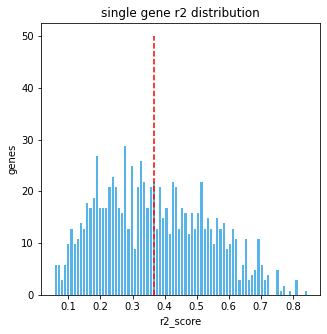

In [ ]:
epoch_n = 5000

r2_dict = {}

for trial in ['trial1','trial2','trial3','noise_trial1','noise_trial2','noise_trial3']:
    valid_data = np.load(f'drive/MyDrive/AIforGenomics2021/ADAGE/trained_model/{trial}/valid_data_allsample_landmark_gene.npy')
    r2_dict[trial] = {}
    for node_n in [50, 100]:
        r2_dict[trial][node_n] = []
        for layers in [1, 5, 10]:
            # calculate r2 per gene to show relation between original gene expression and reconstruct gene expression
            model_name_epoch=f"{trial}/{layers}layers_{node_n}nodes_allsample_landmark_gene/epoch{epoch_n}"
            DA = Adage_linear(train_data.shape[1], node_number=node_n, decoder_layers = layers)
            DA.load_state_dict(torch.load(f'{work_dir}/trained_model/{model_name_epoch}'))

            valid_data_ = DA(torch.tensor(valid_data).float()).detach().numpy()

            r2_score_record = []
            for g in range(valid_data.shape[1]):
                r2_score_record.append(r2_score(valid_data[:,g], valid_data_[:,g]))
            r2_mean = sum(r2_score_record)/len(r2_score_record)
            print('===',model_name_epoch)
            print('average r2 score on valid dataset:',r2_mean)
            r2_dict[trial][node_n].append(r2_mean)

            %matplotlib inline
            plt.figure(figsize=(5,5))
            ax = plt.subplot(1, 1, 1)
            ax.hist(r2_score_record, color = '#56B4E9', edgecolor = 'white',bins = int(80))
            ax.vlines(sum(r2_score_record)/978, ymin=0, ymax=50, colors= 'red',linestyles='dashed')
            # Add labels
            ax.set_title(f'single gene r2 distribution')
            ax.set_xlabel('r2_score')
            ax.set_ylabel('genes')
            plt.show()
            plt.savefig(f'{work_dir}/trained_model/{model_name_epoch}_valid_r2_distribution.pdf')
            plt.close()

            with open(f'{work_dir}/trained_model/{model_name_epoch}.tsv','w+') as f:
                f.write('gene\tr2_score\n')
                for i in range(len(r2_score_record)):
                    f.write(f'{landmark_gene_list.iloc[i].pr_gene_symbol}\t{r2_score_record[i]}\n')


Text(0, 0.5, 'r2 score')

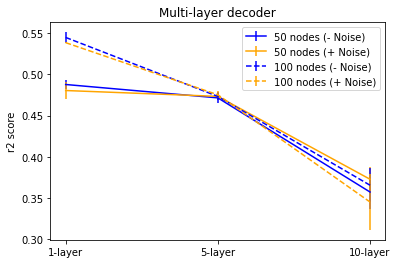

In [ ]:
from statistics import mean, stdev

plt.figure()

for x in range(2):
    node = [50, 100][x]
    linestyle = ['solid','dashed'][x]
    ave=[mean([r2_dict[f'trial{i}'][node][n] for i in [1,2,3]]) for n in range(3)]
    stdev1=[stdev([r2_dict[f'trial{i}'][node][n] for i in range(1,4)]) for n in range(3)]
    plt.errorbar([0, 1, 2], ave, yerr=stdev1, label=f'{node} nodes (- Noise)', color='blue',linestyle=linestyle, linewidth=1.5)

    ave=[mean([r2_dict[f'noise_trial{i}'][node][n] for i in [1,2,3]]) for n in range(3)]
    stdev2=[stdev([r2_dict[f'noise_trial{i}'][node][n] for i in range(1,4)]) for n in range(3)]
    plt.errorbar([0, 1, 2], ave, yerr=stdev2, label=f'{node} nodes (+ Noise)', color='orange',linestyle=linestyle, linewidth=1.5)


ticks = [0, 1, 2]
labels = ["1-layer", "5-layer", "10-layer"]

plt.xticks(ticks, labels)
plt.title('Multi-layer decoder')
plt.legend(loc="upper right")
plt.ylabel('r2 score')